In [95]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import configparser

In [96]:
# -- Functions

%run functions.ipynb

In [97]:
# -- Init Configuration Parameters

%run predict_notebook_sections/configuration.ipynb

In [98]:
# -- Init

# Load data sets config
data_sets_config = load_data_sets_config(data_sets_config_file_path)

In [99]:
data_sets = {
    "cpu-stress" : [
        "linear-cpu-stress-userapi-051516",
        "linear-cpu-stress-redis-091514"
    ], 
    "memory-stress" : [
        "linear-memory-stress-userapi-051218",
        "linear-memory-stress-redis-091522"
    ], 
    "network-delay" : [
        "linear-network-delay-userapi-051816",
        "linear-network-delay-redis-092016"
    ]
}

Each plot shows the prediction and localization results related to different types of failures (CPU Stress, Memory Loss, Network packet delay)
Each plot contains 2 lines. Each line reflects the results on different data sets (depending on the service the failure was injected).
Lines from to the bottom to the top: 
 - Results on the data collected during the execution with the failure injected into the USERAPI service of the appalication 
 - Results on the data collected during the execution with the failure injected into the REDIS service of the appalication 

Each cell has a specific color depending on the result of Predictions/Localization within the corresponding timestamp:
 - Yellow: No predition 
 - Pink: False positive predition (predition on the pediof before the failure injection) or the true positive prediciton without correct localization 
 - Light blue: True positive prediciton with weak localization 
 - Blue: True positive prediciton with strong localization 
 - Red: System

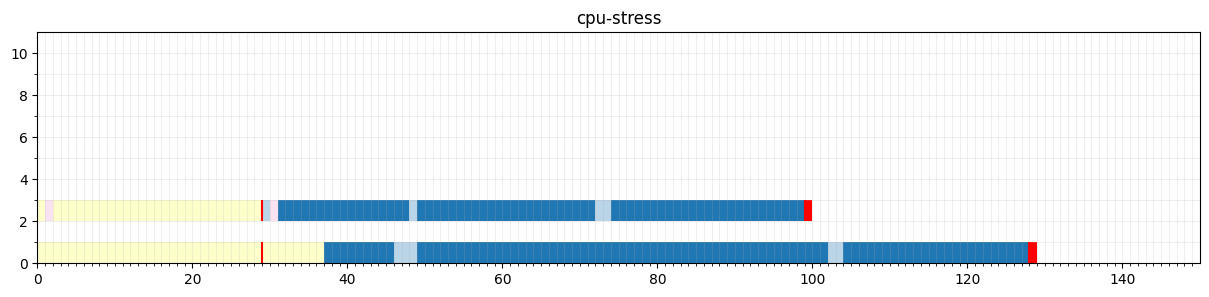

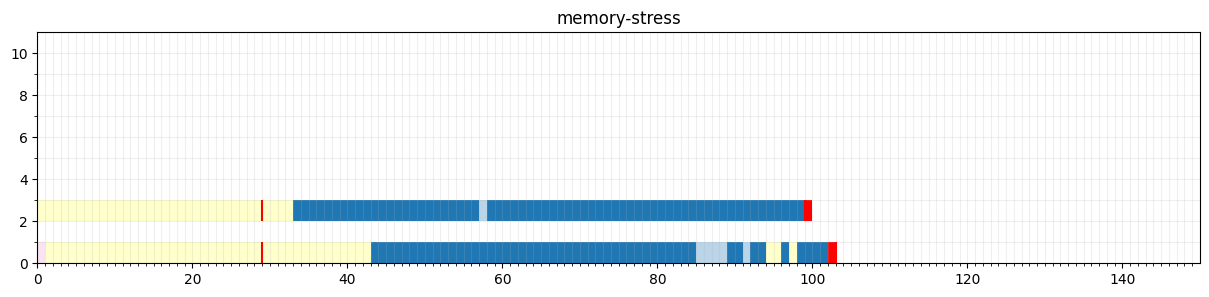

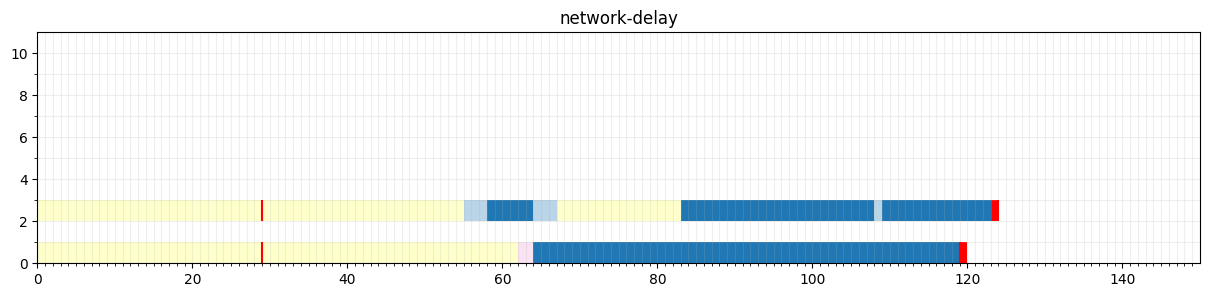

In [100]:
# -- Predictions/Localizations Visualisation

print("Each plot shows the prediction and localization results related to different types of failures (CPU Stress, Memory Loss, Network packet delay)")
print("Each plot contains 2 lines. Each line reflects the results on different data sets (depending on the service the failure was injected).")
print("Lines from to the bottom to the top:", "\n"
      " - Results on the data collected during the execution with the failure injected into the USERAPI service of the appalication", "\n"
      " - Results on the data collected during the execution with the failure injected into the REDIS service of the appalication", "\n"
     )
print("Each cell has a specific color depending on the result of Predictions/Localization within the corresponding timestamp:")
print(
      " - Yellow: No predition", "\n"
      " - Pink: False positive predition (predition on the pediof before the failure injection) or the true positive prediciton without correct localization", "\n"
      " - Light blue: True positive prediciton with weak localization", "\n"
      " - Blue: True positive prediciton with strong localization", "\n"
      " - Red: System disruption", "\n"
     )
print("Vertical red line depicts the failure injection moment")


# sliding window size: 20 minutes
if use_re_sliding_window:
    localisations_file = localisations_by_reconstruction_error_sliding_window_file_path
    
print(localisations_file)

for failure_type in data_sets:
    
    print(failure_type)

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.set_title(failure_type)
    ax.set_xlim([1, 150])
    ax.set_ylim([0, 11], auto=False)
    minor_ticks_x = np.arange(0, 150, 1)
    minor_ticks_y = np.arange(0, 11, 1)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='both', alpha=0.2)

    for data_set_code_idx, data_set_code in enumerate(data_sets[failure_type]):
        
        print(data_set_code)

        if "userapi" in data_set_code:
            attacked_services = ["userapi"]

        if "redis" in data_set_code:
            attacked_services = ["redis-master", "redis"]

        attacked_services = attacked_services + ["alms-core-" + service for service in attacked_services]

        # Load predictions
        with open(predictions_file_path.format(data_set_code=data_set_code), newline='') as csvfile:
            csv_reader = csv.reader(csvfile)
            predictions = [int(row[0]) for row in csv_reader]

        # Load localizations. 1 if the one of the faulty nodes is in top 1, 0 otherwise
        # Define Final localizations
        with open(localisations_file.format(data_set_code=data_set_code), "r") as file_in:
            csv_reader = csv.reader(file_in, delimiter=',')

            localizations = []
            for row_idx, row in enumerate(csv_reader):

                top_1 = ""
                top_2 = ""
                top_3 = ""

                rank_1 = 0
                rank_2 = 0
                rank_3 = 0

                top_list = []

                if len(row) > 2:
                    top_1 = row[2]
                    rank_1 = row[3]

                if len(row) > 4:
                    top_2 = row[4]
                    rank_2 = row[5]

                if len(row) > 6:
                    top_3 = row[6]
                    rank_3 = row[7]

                if top_1 != "":
                    if rank_1 == rank_2 == rank_3:
                        top_list = [top_1, top_2, top_3]
                    else:        
                        if rank_1 == rank_2:
                            top_list = [top_1, top_2]
                        else:
                            top_list = [top_1]

                localization = 0
                for attacked_service in attacked_services:
                    if attacked_service in top_list:
                        localization = 1
                        break

                # Weak localization using precense in top-2 or top-3
                if localization == 0:
                    for attacked_service in attacked_services:
                        if attacked_service in [top_2, top_3]:
                            # print(data_set_code, row_idx + 1)
                            localization = 2
                            break

                localizations.append(localization)


        # Get the Failure injection and the System Disruption points
        fi_point = data_sets_config[data_set_code][1]
        fa_point = data_sets_config[data_set_code][2]

        # Get the Predictions and Localizations of the period from the start of the experiment to the system disruption point
        predictions = predictions[:fa_point - 1]
        localizations = localizations[:fa_point - 1]
        
        if data_set_code == "linear-memory-stress-userapi-051218":
            predictions = predictions[1 :]
            localizations = localizations[1 :]
            fi_point -= 1
            
        if data_set_code == "linear-network-delay-redis-092016":
            predictions = predictions[1 :]
            localizations = localizations[1 :]
            fi_point -= 1

        # - Vizaulization (one plot per failure type
        
        line_shift = data_set_code_idx * 2

        ax.vlines(fi_point - 1, line_shift + 1, line_shift, color="red")
        ax.vlines(fa_point - 1, line_shift + 1, line_shift, color="red")

        for time_point, prediction in enumerate(predictions):
            localization = localizations[time_point]

            if prediction == 1:
                if (time_point + 1) < fi_point:
                        
                    ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:pink'), alpha=0.2)
                else:

                    if localization == 1:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=1)

                    if localization == 2:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=0.3)

                    if localization == 0:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:pink'), alpha=0.2)
            else:
                ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('yellow'), alpha=0.2)

        ax.broken_barh([(time_point + 1, 1)], (line_shift, 1.0), facecolors=('red'), alpha=1)